# Assignment 2 - Titanic Dataset Solutions

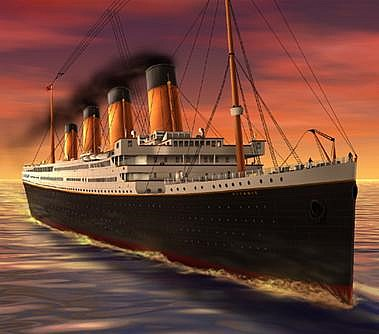

# Abstract

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. This Dataset made by Kaggle requires Ensemble/Stacking in order to find the greatest accuracy in predicting and which model to use. H2O being a new strategy to stack/ensemble with, gives us the opportunity to measure the effectiveness of it, while comparing it to other stacking methods. 

We use H2O with a variety of models, except Deep Learning, while trying to improve our accuracy. With a low RSME we turn to the Kaggle Kernels that get a much higher accuracy, however after applying models of my choosing with Random Forest and GridSearchCV our accuracies and scores increase over the last. The finaly accuracy also improves on the kaggle kernel.

## Import Libraries & Dataset

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn import metrics
import pylab as pl

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
combine = [train, test]

 ## Understanding train dataset

In [3]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
train.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Understanding test dataset

In [8]:
print(test.columns.values)

['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [9]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [10]:
test.tail(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [11]:
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## Feature Exploration, Engineering and Cleaning

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

Titanic Best Working Classfier : by Sina
(https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)

In [12]:
# Some features of my own that I have added in
# Gives the length of the name
train['Name_charlength'] = train['Name'].apply(len)
test['Name_charlength'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in combine:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in combine:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in combine:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [13]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [14]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_charlength,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


For all datasets: Test, Train and Combine


| Column Heading  | Definition              |
| ----------------|------------------------:|
| Survived        | 0 for dead, 1 for Alive |
| Pclass          | Seat Class 1 to 3       |
| Sex             | 1 for Male, 0 for Female|
| Age             | Age Class between 0 & 4 |
| Parch           | Parents & Childern      |
| Fare            | Cost between 0 and 3    |
| Embarked        | 0 for No, 1 for Yes     |
| Name_charlength | Character length of Name|
| Has_Cabin       | 0 for No, 1 for Yes     |
| FamilySize      | Size of Family          |
| IsAlone         | 0 for No, 1 for Yes     |
| Title           | Mr,Mrs,Mis - 0,1,2      |

#### Matplotlib - Heatplot

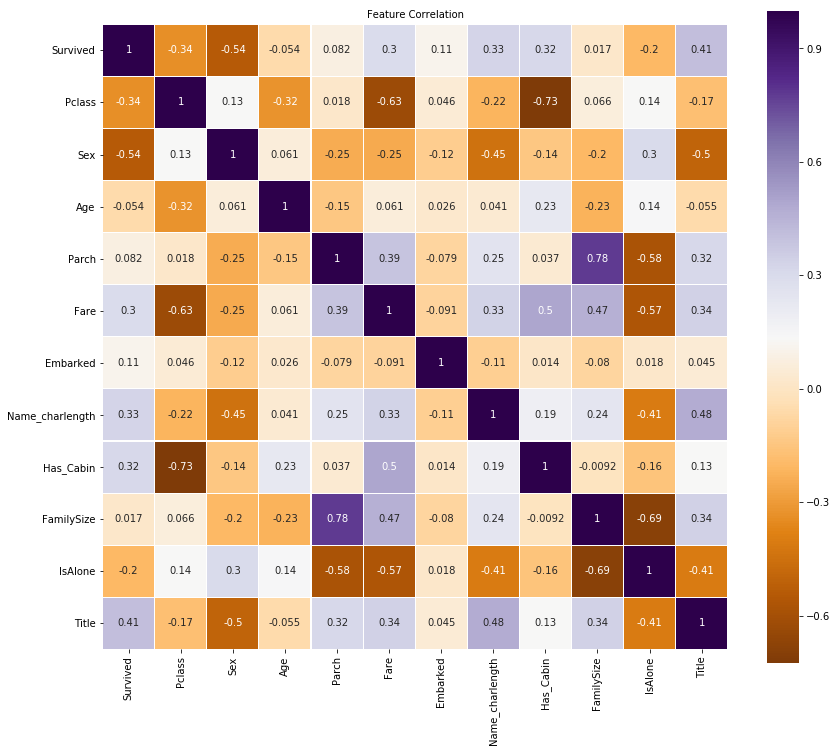

In [15]:
colormap = plt.cm.PuOr
plt.figure(figsize=(14,12))
plt.title('Feature Correlation', y=1, size=10)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

__Takeaway from the Heatplot__

One thing that that the Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two sets of features that are the most correlated, these are: Family size - Parch (Parents and Children) & Fare - Has_Cabin, with a correlation of 0.78 and 0.5 out of 1 repectively. 

#### Seaborns - Pairplot

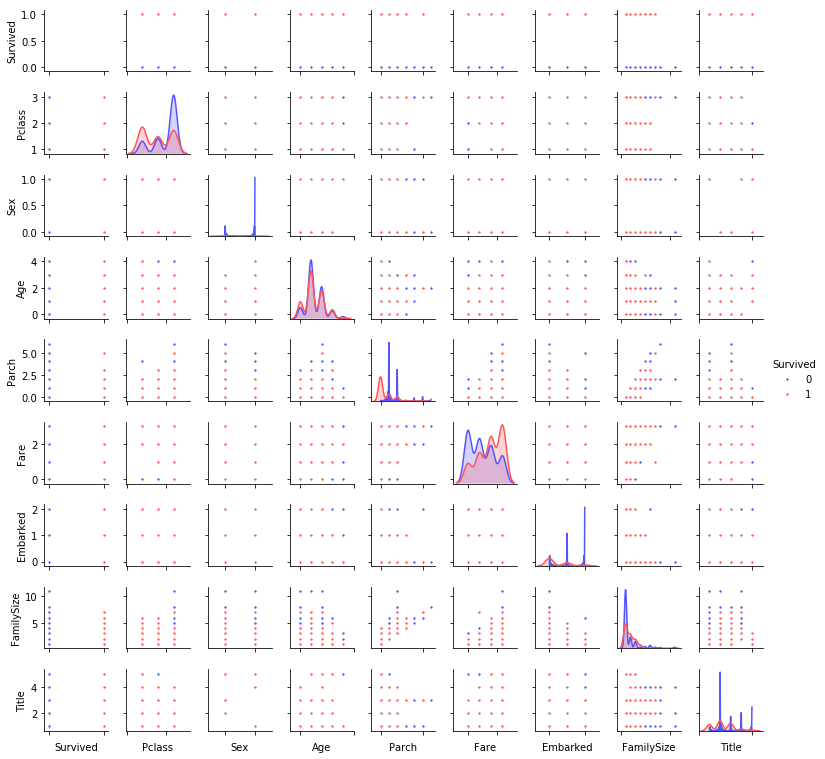

In [16]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

# H2O Implementation (Ensembling & Stacking)

In [17]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [18]:
target='Fare'
min_mem_size=6
run_time=333

In [19]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

1


In [20]:
# 65535 Highest port no
port_no=random.randint(5555,55555)

try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:29886..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.2" 2019-01-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.2+9-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from /anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9p/q_7fdfmx5h97q6mt5rj9cfl00000gn/T/tmp8ajrtqjl
  JVM stdout: /var/folders/9p/q_7fdfmx5h97q6mt5rj9cfl00000gn/T/tmp8ajrtqjl/h2o_sid_macbookpro_started_from_python.out
  JVM stderr: /var/folders/9p/q_7fdfmx5h97q6mt5rj9cfl00000gn/T/tmp8ajrtqjl/h2o_sid_macbookpro_started_from_python.err
  Server is running at http://127.0.0.1:29886
Connecting to H2O server at http://127.0.0.1:29886... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_sid_macbookpro_2tbxcn
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [21]:
df = h2o.import_file(path = 'train.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [23]:
X=get_independent_variables(df, target) 
print(X)

['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Ticket', 'Sex', 'Cabin', 'Embarked', 'Name', 'Age']


In [24]:
# Set target and predictor variables
y = target

## Regression

In [25]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [26]:
model_start_time = time.time()
  
try:
  aml.train(x=X,y=y,training_frame=df)  # Change training_frame=train
except Exception as e:
  logging.critical('aml.train') 
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()   
  sys.exit(4)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [27]:
meta_data={}
meta_data['model_execution_time'] = {"regression":(time.time() - model_start_time)}

In [28]:
meta_data

{'model_execution_time': {'regression': 86.04923295974731}}

In [29]:
print(aml.leaderboard)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190301_193345,1069.38,32.7014,1069.38,12.5868,0.584856
GBM_grid_1_AutoML_20190301_193345_model_23,1070.8,32.723,1070.8,12.4315,0.613128
GBM_4_AutoML_20190301_193345,1105.33,33.2465,1105.33,10.6953,0.540533
GBM_grid_1_AutoML_20190301_193345_model_3,1111.58,33.3403,1111.58,11.4732,0.569532
GBM_grid_1_AutoML_20190301_193345_model_48,1115.92,33.4055,1115.92,12.2417,0.609308
GBM_grid_1_AutoML_20190301_193345_model_35,1117.98,33.4361,1117.98,12.0935,0.570412
GBM_grid_1_AutoML_20190301_193345_model_34,1121.71,33.4919,1121.71,11.9403,0.582016
GBM_grid_1_AutoML_20190301_193345_model_29,1127.1,33.5724,1127.1,12.6074,nan
GBM_3_AutoML_20190301_193345,1147.02,33.8677,1147.02,10.916,0.548768
StackedEnsemble_AllModels_AutoML_20190301_193345,1149.69,33.907,1149.69,13.2262,0.618205


## Best Model

In [30]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])

In [31]:
best_model.algo

'gbm'

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

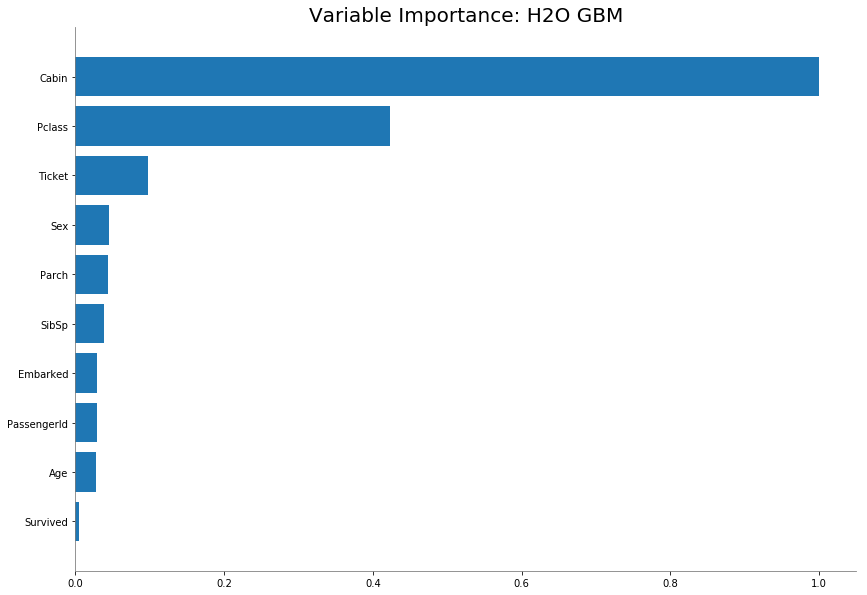

In [33]:
# Variable Importance with 'Fare' as the main correlation
best_model.varimp_plot()

In [34]:
print(best_model.rmse(train = True))

20.082194105220132


In [35]:
print(best_model.mse(train = True))

403.2945200797383


In [36]:
print(best_model.mae(train = True))

5.2144985814421


## Cross Validation and Target Encoding

In [37]:
cv_nfolds = 5
cv_seed = 2307

In [38]:
train=df

In [39]:
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

In [40]:
train["cv_fold"].table()

cv_fold,Count
0,172
1,192
2,180
3,184
4,163


In [41]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [42]:
def mean_target(data, x, y = "Cabin"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [43]:
def mean_target_encoding(data, x, y = "Cabin", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

# Kaggle Kernels

- Completed by Lan Mei [(Lissie)](https://www.kaggle.com/itslissie/titanic-survival-predictions-beginner-lan)
- Team Name: __lissie33__
- Leaderboard Rank: __2420__
- Accuracy: __0.78947__

#### Contents:
1. Import Necessary Libraries
2. Read In and Explore the Data
3. Data Analysis
4. Data Visualization
5. Cleaning Data
6. Choosing the Best Model
7. Creating Submission File

Any and all feedback is welcome!

### 1) Import Necessary Libraries
First off, we need to import several Python libraries such as numpy, pandas, matplotlib and seaborn.


In [44]:
#data analysis libraries 
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 2) Read in and Explore the Data
It's time to read in our training and testing data using pd.read_csv, and take a first look at the training data using the describe() function.

In [45]:
#import train and test CSV files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#take a look at the training data
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Maioni, Miss. Roberta",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 3) Data Analysis
We're going to consider the features in the dataset and how complete they are.

In [46]:
#get a list of the features within the dataset
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [47]:
#see a sample of the dataset to get an idea of the variables
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C
114,115,0,3,"Attalah, Miss. Malake",female,17.0,0,0,2627,14.4583,NaN,C
105,106,0,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S
687,688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S


* **Numerical Features:** Age (Continuous), Fare (Continuous), SibSp (Discrete), Parch (Discrete)
* **Categorical Features:** Survived, Sex, Embarked, Pclass
* **Alphanumeric Features:** Ticket, Cabin

#### What are the data types for each feature?
* Survived: int
* Pclass: int
* Name: string
* Sex: string
* Age: float
* SibSp: int
* Parch: int
* Ticket: string
* Fare: float
* Cabin: string
* Embarked: string

Now that we have an idea of what kinds of features we're working with, we can see how much information we have about each of them.


In [48]:
#see a summary of the training dataset
train.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Maioni, Miss. Roberta",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


#### Some Observations:
* There are a total of 891 passengers in our training set.
* The Age feature is missing approximately 19.8% of its values. I'm guessing that the Age feature is pretty important to survival, so we should probably attempt to fill these gaps. 
* The Cabin feature is missing approximately 77.1% of its values. Since so much of the feature is missing, it would be hard to fill in the missing values. We'll probably drop these values from our dataset.
* The Embarked feature is missing 0.22% of its values, which should be relatively harmless.

In [49]:
#check for any other unusable values
print(pd.isnull(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


We can see that except for the abovementioned missing values, no NaN values exist.

### Some Predictions:
* Sex: Females are more likely to survive.
* SibSp/Parch: People traveling alone are more likely to survive.
* Age: Young children are more likely to survive.
* Pclass: People of higher socioeconomic class are more likely to survive.

### 4) Data Visualization
It's time to visualize our data so we can see whether our predictions were accurate!

### Sex Feature

Percentage of females who survived: 74.20382165605095
Percentage of males who survived: 18.890814558058924


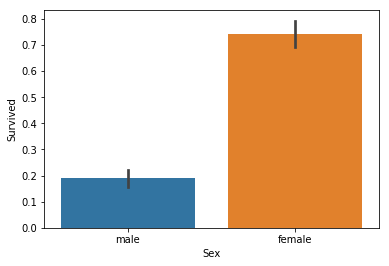

In [50]:
#draw a bar plot of survival by sex
sns.barplot(x="Sex", y="Survived", data=train)

#print percentages of females vs. males that survive
print("Percentage of females who survived:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Percentage of males who survived:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

### Pclass Feature

Percentage of Pclass = 1 who survived: 62.96296296296296
Percentage of Pclass = 2 who survived: 47.28260869565217
Percentage of Pclass = 3 who survived: 24.236252545824847


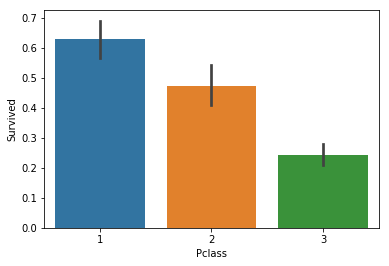

In [51]:
#draw a bar plot of survival by Pclass
sns.barplot(x="Pclass", y="Survived", data=train)

#print percentage of people by Pclass that survived
print("Percentage of Pclass = 1 who survived:", train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 2 who survived:", train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 3 who survived:", train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

### SibSp Feature

Percentage of SibSp = 0 who survived: 34.53947368421053
Percentage of SibSp = 1 who survived: 53.588516746411486
Percentage of SibSp = 2 who survived: 46.42857142857143


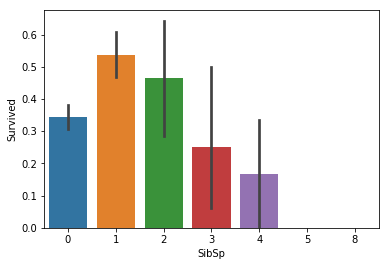

In [52]:
#draw a bar plot for SibSp vs. survival
sns.barplot(x="SibSp", y="Survived", data=train)

#I won't be printing individual percent values for all of these.
print("Percentage of SibSp = 0 who survived:", train["Survived"][train["SibSp"] == 0].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 1 who survived:", train["Survived"][train["SibSp"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 2 who survived:", train["Survived"][train["SibSp"] == 2].value_counts(normalize = True)[1]*100)

In general, it's clear that people with more siblings or spouses aboard were less likely to survive. However, contrary to expectations, people with no siblings or spouses were less to likely to survive than those with one or two. (34.5% vs 53.4% vs. 46.4%)

### Parch Feature

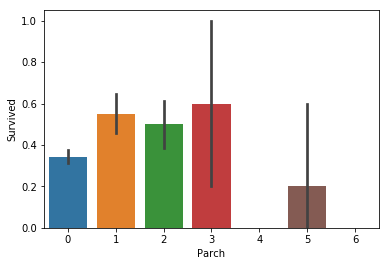

In [53]:
#draw a bar plot for Parch vs. survival
sns.barplot(x="Parch", y="Survived", data=train)
plt.show()

People with less than four parents or children aboard are more likely to survive than those with four or more. Again, people traveling alone are less likely to survive than those with 1-3 parents or children.

### Age Feature

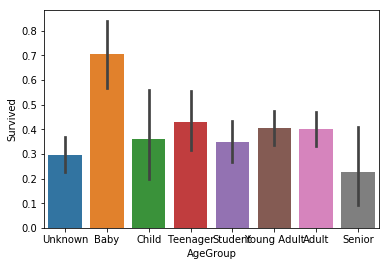

In [54]:
#sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

Babies are more likely to survive than any other age group. 

### Cabin Feature
I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. Thanks for the tips, [@salvus82](https://www.kaggle.com/salvus82) and [Daniel Ellis](https://www.kaggle.com/dellis83)!

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


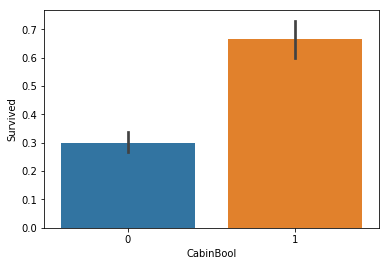

In [55]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
#draw a bar plot of CabinBool vs. survival
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

People with a recorded Cabin number are, in fact, more likely to survive. (66.6% vs 29.9%)

## 5) Cleaning Data
Time to clean our data to account for missing values and unnecessary information!

### Looking at the Test Data
Let's see how our test data looks!

In [56]:
test.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool
count,418.000000,418.000000,418,418,418.000000,418.000000,418.000000,418,417.000000,91,418,418,418.000000
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3,8,NaN
top,NaN,NaN,"Wells, Mrs. Arthur Henry (Addie"" Dart Trevaskis)""",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S,Young Adult,NaN
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270,96,NaN
mean,1100.500000,2.265550,NaN,NaN,23.941388,0.447368,0.392344,NaN,35.627188,NaN,NaN,NaN,0.217703
std,120.810458,0.841838,NaN,NaN,17.741080,0.896760,0.981429,NaN,55.907576,NaN,NaN,NaN,0.413179
min,892.000000,1.000000,NaN,NaN,-0.500000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,996.250000,1.000000,NaN,NaN,9.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,0.000000
50%,1100.500000,3.000000,NaN,NaN,24.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,0.000000
75%,1204.750000,3.000000,NaN,NaN,35.750000,1.000000,0.000000,NaN,31.500000,NaN,NaN,NaN,0.000000


* We have a total of 418 passengers.
* 1 value from the Fare feature is missing.
* Around 20.5% of the Age feature is missing, we will need to fill that in.

### Cabin Feature

In [57]:
#we'll start off by dropping the Cabin feature since not a lot more useful information can be extracted from it.
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

### Ticket Feature

In [58]:
#we can also drop the Ticket feature since it's unlikely to yield any useful information
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

### Embarked Feature

In [59]:
#now we need to fill in the missing values in the Embarked feature
print("Number of people embarking in Southampton (S):")
southampton = train[train["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = train[train["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = train[train["Embarked"] == "Q"].shape[0]
print(queenstown)

Number of people embarking in Southampton (S):
644
Number of people embarking in Cherbourg (C):
168
Number of people embarking in Queenstown (Q):
77


It's clear that the majority of people embarked in Southampton (S). Let's go ahead and fill in the missing values with S.

In [60]:
#replacing the missing values in the Embarked feature with S
train = train.fillna({"Embarked": "S"})

### Age Feature

Next we'll fill in the missing values in the Age feature. Since a higher percentage of values are missing, it would be illogical to fill all of them with the same value (as we did with Embarked). Instead, let's try to find a way to predict the missing ages. 

In [61]:
#create a combined group of both datasets
combine = [train, test]

#extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [62]:
#replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [63]:
#map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Student,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Adult,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Young Adult,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Young Adult,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Young Adult,0,1


The code I used above is from [here](https://www.kaggle.com/startupsci/titanic-data-science-solutions). Next, we'll try to predict the missing Age values from the most common age for their Title.

In [64]:
# fill missing age with mode age group for each title
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

#I tried to get this code to work with using .map(), but couldn't.
#I've put down a less elegant, temporary solution for now.
#train = train.fillna({"Age": train["Title"].map(age_title_mapping)})
#test = test.fillna({"Age": test["Title"].map(age_title_mapping)})

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]
        
for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

Now that we've filled in the missing values at least *somewhat* accurately (I will work on a better way for predicting missing age values), it's time to map each age group to a numerical value.

In [65]:
#map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

#dropping the Age feature for now, might change
train = train.drop(['Age'], axis = 1)
test = test.drop(['Age'], axis = 1)

### Name Feature
We can drop the name feature now that we've extracted the titles.

In [66]:
#drop the name feature since it contains no more useful information.
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

### Sex Feature

In [67]:
#map each Sex value to a numerical value
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.2500,S,4,0,1
1,2,1,1,1,1,0,71.2833,C,6,1,3
2,3,1,3,1,0,0,7.9250,S,5,0,2
3,4,1,1,1,1,0,53.1000,S,5,1,3
4,5,0,3,0,0,0,8.0500,S,5,0,1


In [68]:
### Embarked Feature

In [69]:
#map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.2500,1,4,0,1
1,2,1,1,1,1,0,71.2833,2,6,1,3
2,3,1,3,1,0,0,7.9250,1,5,0,2
3,4,1,1,1,1,0,53.1000,1,5,1,3
4,5,0,3,0,0,0,8.0500,1,5,0,1


In [70]:
### Fare Feature
It's time separate the fare values into some logical groups as well as filling in the single missing value in the test dataset.

SyntaxError: EOL while scanning string literal (<ipython-input-70-eeea330cedc3>, line 2)

In [71]:
#fill in missing Fare value in test set based on mean fare for that Pclass 
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x] #Pclass = 3
        test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)
        
#map Fare values into groups of numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels = [1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels = [1, 2, 3, 4])

#drop Fare values
train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)

In [72]:
#check train data
train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,CabinBool,Title,FareBand
0,1,0,3,0,1,0,1,4,0,1,1
1,2,1,1,1,1,0,2,6,1,3,4
2,3,1,3,1,0,0,1,5,0,2,2
3,4,1,1,1,1,0,1,5,1,3,4
4,5,0,3,0,0,0,1,5,0,1,2


In [73]:
#check test data
test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,CabinBool,Title,FareBand
0,892,3,0,0,0,3,5,0,1,1
1,893,3,1,1,0,1,6,0,3,1
2,894,2,0,0,0,3,7,0,1,2
3,895,3,0,0,0,1,5,0,1,2
4,896,3,1,1,1,1,4,0,3,2


## 6) Choosing the Best Model

### Splitting the Training Data
We will use part of our training data (22% in this case) to test the accuracy of our different models.

In [76]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

### Testing Different Models
I will be testing the following models with my training data (got the list from [here](http://https://www.kaggle.com/startupsci/titanic-data-science-solutions)):
* Gaussian Naive Bayes
* Logistic Regression
* Support Vector Machines
* Perceptron
* Decision Tree Classifier
* Random Forest Classifier
* KNN or k-Nearest Neighbors
* Stochastic Gradient Descent
* Gradient Boosting Classifier

For each model, we set the model, fit it with 80% of our training data, predict for 20% of the training data and check the accuracy.

In [78]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

78.68


In [79]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

79.19


In [80]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

82.74


In [81]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

78.68


In [82]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

79.19


In [83]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

80.71


In [84]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

81.22


In [85]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

77.66


In [86]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

78.68


In [87]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

84.77


Let's compare the accuracies of each model!

In [88]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk]})
models.sort_values(by='Score', ascending=False)

,Model,Score
9,Gradient Boosting Classifier,84.77
0,Support Vector Machines,82.74
3,Random Forest,81.22
7,Decision Tree,80.71
2,Logistic Regression,79.19
5,Perceptron,79.19
4,Naive Bayes,78.68
6,Linear SVC,78.68
8,Stochastic Gradient Descent,78.68
1,KNN,77.66


I decided to use the Gradient Boosting Classifier model for the testing data.

## Sources:
* [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)
* [Scikit-Learn ML from Start to Finish](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish?scriptVersionId=320209)

Any and all feedback is welcome! 

# Own Work (Expand of Kernel)

In [89]:
import numpy as np
import pandas as pd

import os
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [90]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.shape, test_df.shape

((891, 12), (418, 11))

In [91]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [92]:
y = train_df['Survived']
train_df.drop('Survived', axis=1, inplace=True)

combin = pd.concat([train_df, test_df])
combin.shape

(1309, 11)

In [93]:
combin['Name'] = [i.split(',')[1].split('.')[0].strip() for i in combin['Name']]

In [94]:
combin['Name'] = combin['Name'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
combin['Name'] = combin['Name'].replace('Mlle', 'Miss')
combin['Name'] = combin['Name'].replace('Ms', 'Miss')
combin['Name'] = combin['Name'].replace('Mme', 'Mrs')

In [95]:
combin.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [96]:
combin['Has_Cabin'] = combin["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [97]:
combin['FamilySize'] = combin['SibSp'] + combin['Parch'] + 1

combin['IsAlone'] = 0
combin.loc[combin['FamilySize'] == 1, 'IsAlone'] = 1

In [98]:
age_avg = combin['Age'].mean()
age_std = combin['Age'].std()
age_null_count = combin['Age'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
combin['Age'][np.isnan(combin['Age'])] = age_null_random_list
combin['Age'] = combin['Age'].astype(int)

In [99]:
combin['Fare'].fillna(combin['Fare'].median(), inplace=True)

In [100]:
combin.loc[ combin['Fare'] <= 7.91, 'Fare']                              = 0
combin.loc[(combin['Fare'] > 7.91) & (combin['Fare'] <= 14.454), 'Fare'] = 1
combin.loc[(combin['Fare'] > 14.454) & (combin['Fare'] <= 31), 'Fare']   = 2
combin.loc[ combin['Fare'] > 31, 'Fare']                                 = 3
combin['Fare'] = combin['Fare'].astype(int)

In [101]:
combin.loc[ combin['Age'] <= 16, 'Age']                         = 0
combin.loc[(combin['Age'] > 16) & (combin['Age'] <= 32), 'Age'] = 1
combin.loc[(combin['Age'] > 32) & (combin['Age'] <= 48), 'Age'] = 2
combin.loc[(combin['Age'] > 48) & (combin['Age'] <= 64), 'Age'] = 3
combin.loc[ combin['Age'] > 64, 'Age']                          = 4 

In [102]:
combin['Embarked'] = combin['Embarked'].fillna('C')

In [103]:
drop_elements = ['PassengerId', 'Ticket', 'Cabin', 'SibSp']
combin = combin.drop(drop_elements, axis = 1)

In [104]:
combin.isnull().sum()

Pclass        0
Name          0
Sex           0
Age           0
Parch         0
Fare          0
Embarked      0
Has_Cabin     0
FamilySize    0
IsAlone       0
dtype: int64

In [105]:
combin_flo = combin.select_dtypes(exclude='object')
combin_cat = combin.select_dtypes(include='object')

In [106]:
combin_cat = pd.get_dummies(combin_cat)

In [107]:
combin = pd.concat([combin_flo, combin_cat], axis=1)
combin.shape

(1309, 17)

In [108]:
combin.isnull().sum().sum()

0

In [109]:
X = combin.iloc[:train_df.shape[0], :]
test = combin.iloc[train_df.shape[0]:, :]

In [110]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
test_norm = scaler.transform(test)

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [112]:
y_train.value_counts()

0    421
1    247
Name: Survived, dtype: int64

In [113]:
y_val.value_counts()

0    128
1     95
Name: Survived, dtype: int64

In [115]:
from sklearn.model_selection import RandomizedSearchCV, KFold

kf = KFold(n_splits = 5, random_state = 1)

rfc_parameters = {'max_depth' : [2, 5, 8, 10, 20, 50], 'n_estimators' : [10, 50, 100, 200, 500, 1000, 2000], 'min_samples_split' : [2, 3, 5, 9, 20]}
rfc = RandomForestClassifier(random_state = 1, n_jobs = -1)
clf_rfc = RandomizedSearchCV(rfc, rfc_parameters, n_jobs = -1, cv = kf, scoring = 'roc_auc')

clf_rfc.fit(X_train, y_train)
print(clf_rfc.best_score_)
print(clf_rfc.score(X_val, y_val))
print(clf_rfc.best_params_)

0.8621426511053434
0.9025904605263158
{'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 5}


In [116]:
lr_paramaters = {'C' : [0.05, 0.1, 0.2], 'random_state' : [1]}
lr = LogisticRegression()

clf_lr = GridSearchCV(lr, lr_paramaters, n_jobs = -1, cv = kf, scoring = 'roc_auc')

clf_lr.fit(X_train, y_train)
print(clf_lr.best_score_)
print(clf_lr.score(X_val, y_val))
print(clf_lr.best_params_)

0.8595654039072153
0.9017680921052632
{'C': 0.2, 'random_state': 1}


In [117]:
svc_paramaters = {'C' : [5.5, 6, 6.5], 'kernel' : ['linear', 'rbf'], 'gamma' : ['auto', 'scale'], 'random_state' : [1]}
svc = SVC(probability=True)

clf_svc = GridSearchCV(svc, svc_paramaters, n_jobs = -1, cv = kf, scoring = 'roc_auc')

clf_svc.fit(X_train, y_train)
print(clf_svc.best_score_)
print(clf_svc.score(X_val, y_val))
print(clf_svc.best_params_)

0.8455691258389714
0.8831003289473683
{'C': 6, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 1}


In [118]:
gbdt_parameters = {'subsample' : [1], 'min_samples_leaf' : [3], 'learning_rate' : [0.1], 'n_estimators' : [50], 'min_samples_split' : [2], 'max_depth' : [3], 'random_state' : [1]}
gbdt = GradientBoostingClassifier()

clf_gbdt = GridSearchCV(gbdt, gbdt_parameters, n_jobs = -1, cv = kf, scoring = 'roc_auc')

clf_gbdt.fit(X_train, y_train)
print(clf_gbdt.best_score_)
print(clf_gbdt.score(X_val, y_val))
print(clf_gbdt.best_params_)

0.8666171778437259
0.9074424342105263
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 1, 'subsample': 1}


In [119]:
classifiers = [
#     ('KNN', KNeighborsClassifier(3)),
    ('SVC', clf_svc),
#     ('DTC', DecisionTreeClassifier()),
    ('RFC', clf_rfc),
#     ('ABC', AdaBoostClassifier()),
    ('GBC', clf_gbdt),
#     ('GNB', GaussianNB()),
#     ('LDA', LinearDiscriminantAnalysis()),
#     ('QDA', QuadraticDiscriminantAnalysis()),
    ('LR', clf_lr)]

In [120]:
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')
voting_clf.fit(X_train, y_train)
score = np.mean(cross_val_score(voting_clf,  X_val, y_val, scoring='accuracy'))
score

0.8252054794520548

In [121]:
voting_clf.score(X_val, y_val)

0.8295964125560538

In [122]:
pred = voting_clf.predict(test)

### Using Kernel Submission code

In [139]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = pred.astype(int)
sub.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


In [130]:

sub.to_csv('dataFrame.csv', index=False)

In [131]:
pred = np.zeros(len(test))

for _, model in classifiers:
    print(model.__class__.__name__)
    model.fit(X, y)
    p = model.predict(test)
    pred = pred + p
pred = pred / len(classifiers)

GridSearchCV
RandomizedSearchCV
GridSearchCV
GridSearchCV


In [132]:
for idx, i in enumerate(pred):
    if i >= 0.7:
        pred[idx] = 1
    else:
        pred[idx] = 0

In [138]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = pred.astype(int)
sub.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,1


In [134]:
models = pd.DataFrame({
    'Model': ['Random Forrest Classifer', 'Logistic Regression', 'Support Vector Classifier', 
              'Gradient Boosting Classifier'],
    'Score': [clf_rfc.best_score_, clf_lr.best_score_, 
              clf_svc.best_score_, clf_gbdt.best_score_]})
models.sort_values(by='Score', ascending=True)

,Model,Score
2,Support Vector Classifier,0.862726
1,Logistic Regression,0.867687
0,Random Forrest Classifer,0.873309
3,Gradient Boosting Classifier,0.877237


In [137]:
sub.to_csv('dataFrame2.csv', index=False)

# Conclusion

Rank 2108

Completing H2O in relation to Regression gave me an RSME result of 20.082, which is infinitely small than in comparison to the notebook completed by Lisslie of 0.78947. Using Gradient Boosting Classifier, Support Vector Machines, Random Forest, Decision Tree, Logistic Regression, Perceptron, Naive Bayes, Linear SVC, Stochastic Gradient Descent, KNN, she found her 3 most varying values from __Gradient Boosting Classifier, Support Vector Machines, Logistic Regression__, considering this I used Random Forest with GridSearchCV & RandomizedSearchCV on the same 3 models and RFC to seek out higher accuracy in the models. 

Doing this I was able to improve upon her accuracy of __0.78947__ to an accuracy of __0.79425__.

# Contribution Statement

- Titanic Dataset made by Kaggle: https://www.kaggle.com/kaggle
- Introduction to Ensembling/Stacking made by Kaggle user, Arthurtok: https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
- H2O guide used from Github user NikBearBrown: https://github.com/nikbearbrown/CSYE_7245/tree/master/H2O

Use of H2O as a stacking/ensembling method with Hyperparameter tuning and testing accuracies or Regressor & Classifer was done by Siddhartha Vale.


# Citations

1. https://www.kaggle.com/jiegeng94/do-you-enjoy-traveling-alone-focus-on-companions
2. https://www.kaggle.com/c/titanic
3. https://www.kaggle.com/rankings?group=kernels&page=1&pageSize=20
4. https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
5. https://www.kaggle.com/startupsci/titanic-data-science-solutions
6. https://github.com/nikbearbrown/CSYE_7245/blob/master/H2O/H2OTutorialsBook.pdf
7. https://github.com/nikbearbrown/CSYE_7245/blob/master/Assignments/Assignment_2_Kaggle.ipynb
8. https://github.com/nikbearbrown/CSYE_7245/blob/master/H2O/H2O_automl_lending_club.ipynb 
9. https://github.com/nikbearbrown/CSYE_7245/blob/master/H2O/H2O_automl_model.ipynb
10. https://opensource.org/licenses/MIT
11. https://www.h2o.ai/?utm_source=google&utm_medium=cpc&utm_term=machine%20learning&utm_campaign=ml&gclid=CjwKCAiAqt7jBRAcEiwAof2uK_oTooCLFT3IvM6BI2D6kgZa_XaS1zO3rdUpeTtyuDnDhxvxAUb8lhoCmGsQAvD_BwE
12. https://xgboost.readthedocs.io/en/latest/build.html
13. https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html
14. https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
15. https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

# License

Copyright __2019 Siddhartha Vale__

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.